Import neccesary packages and toolkits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

Read in data

In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df = df.head(2000)

Observe the data

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

Quick EDA

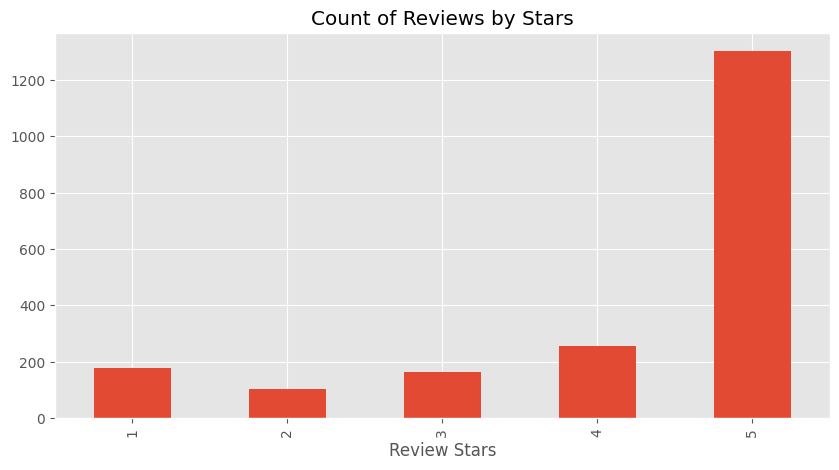

In [5]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

Basic NLTK

In [6]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


VADER Sentiment Scoring
    using NLTK's SentimentIntensityAnalyzer to get negative/neutral/positive scores of text

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Examples of how SentimentIntensityAnalyzer works

In [11]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [12]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

Run on example from dataset

In [13]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

Run the polarity score on the entire dataset

In [14]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/2000 [00:00<?, ?it/s]

Store res dictionary as pandas data frame and merge with original df

In [15]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

Now we have sentiment score and metadata

In [16]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Plot VADER results

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

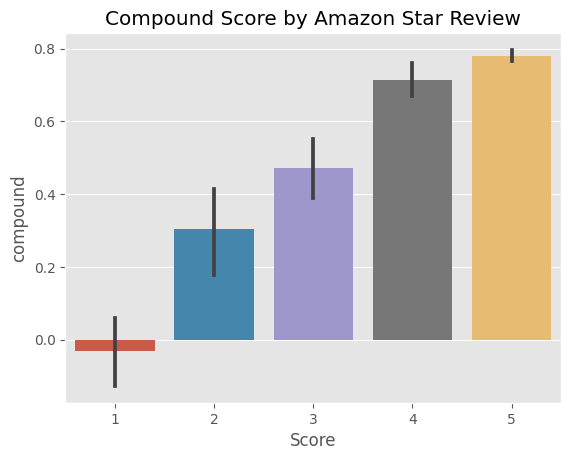

In [17]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')

We can see that VADER is reliable in the terms of the connection between sentiment scores and rating reviews. 

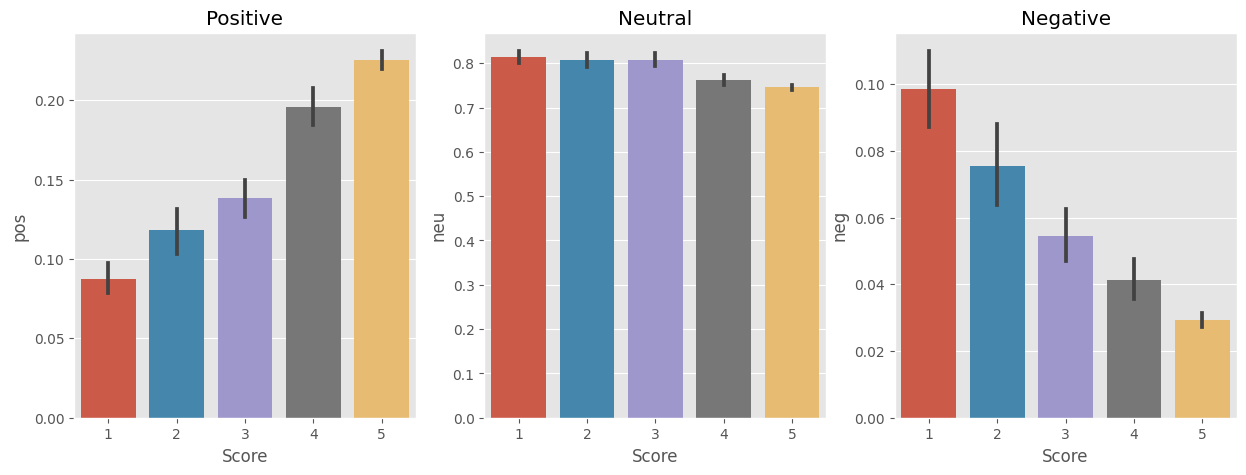

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x = 'Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x = 'Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x = 'Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [19]:
product_counts = df.groupby('ProductId').size().reset_index(name='Count')
product_counts.head(100)

,ProductId,Count
0,B00002Z754,2
1,B000084E1U,1
2,B0000VLH8S,5
3,B0001PB9FE,1
4,B0001PB9FY,1
...,...,...
95,B0016PKA1C,23
96,B0017129DC,1
97,B0017165OG,1
98,B00171APVA,1


In [20]:
newdf = df[df['ProductId'] == 'B0016PKA1C'].copy()

# If you want to reset the index of the new DataFrame
newdf.reset_index(drop=True, inplace=True)
newdf.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1912,B0016PKA1C,A21KEWQVHOIHFJ,ocannie2002,14,14,2,1293321600,Found the solution on how to open it,I bought this because I had been seeing this p...
1,1913,B0016PKA1C,APHB4GY5WEVOP,"Alan Howard ""AHowah""",11,11,5,1244937600,WORKS FOR ME AND SAVES ME $$$$,This product works great for me. I hate spend...
2,1914,B0016PKA1C,A1TPHJAGEOQZQJ,A. Paskow,7,7,5,1245024000,This thing is great!,"I have had my herb savor for a few weeks now, ..."
3,1915,B0016PKA1C,A1BFF0SPH2VZC4,"A. Wise ""Ilikestuff""",4,4,3,1265068800,A little hard to open,I bought this as a gift for my mother. She lik...
4,1916,B0016PKA1C,A1MPHD8OJTXR1R,A. Marvin,3,3,2,1266105600,"Great concept, poor product",I have had the herb pods for about 6 months. ...
5,1917,B0016PKA1C,A36LOFUR3U753Z,L Parr,2,2,2,1304380800,"Too small, too hard to open",With no clear instructions on how to open and ...
6,1918,B0016PKA1C,A32F0SQ7I9PO0L,Barbara J. Conine,1,1,1,1331164800,can't open,Despite reading the reviews of others on how h...
7,1919,B0016PKA1C,A1T277YTLM09T9,B. Cooley,1,1,2,1323561600,"Great idea, such a pain to open and close","The reviews on this are so true. Great idea, b..."
8,1920,B0016PKA1C,A28SD5Y42J7K15,Ms Bailey,1,1,5,1311033600,Keeps basil on the counter...cat proof!,I've had trouble storing fresh basil because I...
9,1921,B0016PKA1C,A19OAB9Y3GT3SO,Jennifer,1,1,1,1305072000,Save your money!,"I rarely write reviews, but these pods are so ..."


In [21]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(newdf)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/23 [00:00<?, ?it/s]

In [22]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(newdf, how='left')

In [23]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.079,0.853,0.068,-0.1027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.091,0.754,0.155,0.8265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.000,0.552,0.448,0.9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
sentiment_score = vaders['compound'].mean()

In [25]:
if sentiment_score > -1 and sentiment_score <= -0.5:
    print("Overall sentiment is very negative")
elif sentiment_score > -0.5 and sentiment_score <= -0.2:
    print("Overall sentiment is negative")
elif sentiment_score > -0.2 and sentiment_score <= 0.2:
    print('Overall sentiment is neutral')
elif sentiment_score > 0.2 and sentiment_score <= 0.5:
    print("Overall sentiment is positive")
else:
    print("Overall sentiment is very positive")

Overall sentiment is very positive
